In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import xgboost

In [3]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) Read in data & explore preliminarily

In [4]:
df = pd.read_csv('home_sales_dataset.csv')
print(df.shape)
df.head()

(1011, 18)


,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,August-24-2021,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,August-24-2021,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,August-23-2021,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,August-23-2021,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,August-23-2021,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [5]:
df['sold_date'] = pd.to_datetime(df['sold_date'])

In [6]:
df.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,2021-08-24,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,2021-08-24,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,2021-08-23,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,2021-08-23,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,2021-08-23,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sold_price   1011 non-null   int64         
 1   beds         1011 non-null   int64         
 2   baths        1011 non-null   float64       
 3   hm_sqft      1011 non-null   int64         
 4   lot_size     1011 non-null   int64         
 5   yr_built     1011 non-null   int64         
 6   zipcode      1011 non-null   int64         
 7   pool         1011 non-null   int64         
 8   garage       1011 non-null   int64         
 9   stories      1011 non-null   int64         
 10  schools      1011 non-null   float64       
 11  sold_date    1011 non-null   datetime64[ns]
 12  address      1011 non-null   object        
 13  days_on_mkt  1011 non-null   int64         
 14  hoa          1011 non-null   int64         
 15  url          1011 non-null   object        
 16  lat   

In [8]:
df.drop(columns=['zipcode', 'lat', 'lon']).describe()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,stories,schools,days_on_mkt,hoa
count,1.011000e+03,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,1.126206e+06,3.633037,2.544510,2081.720079,10828.724036,1960.297725,0.134520,0.140455,1.178042,5.738731,44.678536,2.430267
std,5.022851e+05,0.844819,0.924634,886.574023,15533.545033,11.616964,0.341379,0.347630,0.387876,0.674897,24.281487,24.731666
min,4.000000e+05,1.000000,1.000000,552.000000,2000.000000,1920.000000,0.000000,0.000000,1.000000,4.200000,1.000000,0.000000
25%,8.400000e+05,3.000000,2.000000,1471.000000,7083.000000,1954.000000,0.000000,0.000000,1.000000,5.200000,25.000000,0.000000
50%,9.650000e+05,4.000000,2.000000,1873.000000,8217.000000,1958.000000,0.000000,0.000000,1.000000,5.666667,44.000000,0.000000
75%,1.260000e+06,4.000000,3.000000,2447.000000,11761.000000,1964.000000,0.000000,0.000000,1.000000,6.166667,64.000000,0.000000
max,5.500000e+06,8.000000,8.000000,8189.000000,475675.000000,2021.000000,1.000000,1.000000,3.000000,7.666667,90.000000,585.000000


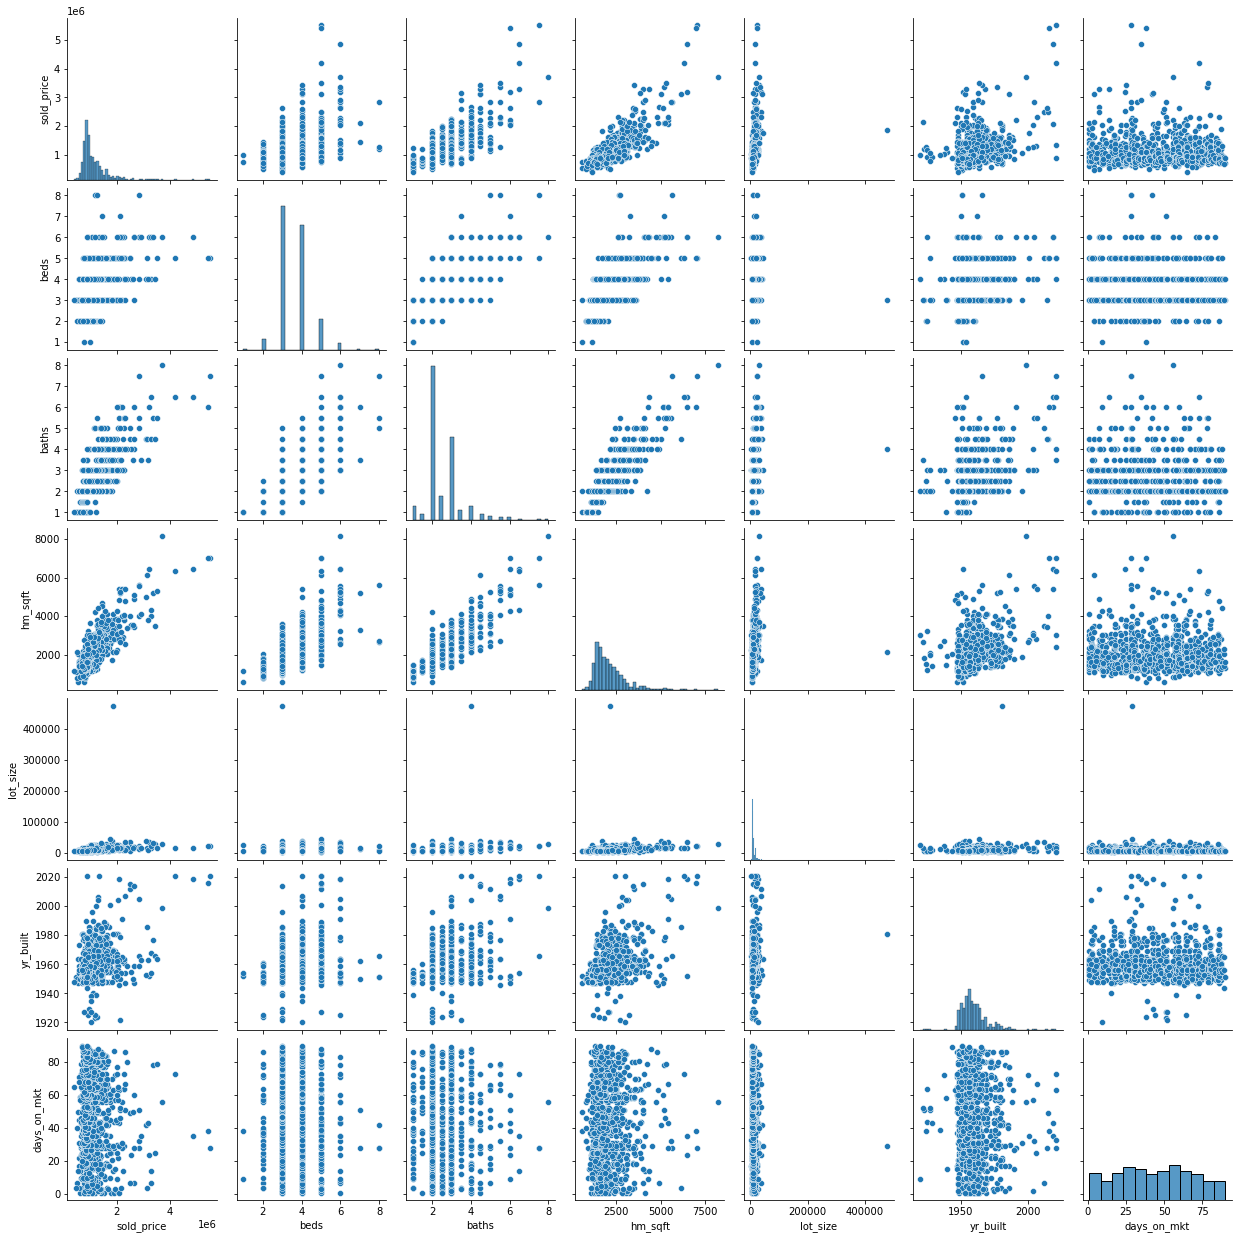

In [9]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']);

#### Drop that one home with a huge lot_size from the dataset (obvious undesirable outlier, not representative of vast majority)

In [10]:
print(df.shape)
df = df[df['lot_size'] < 200000]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(1011, 18)
(1010, 18)


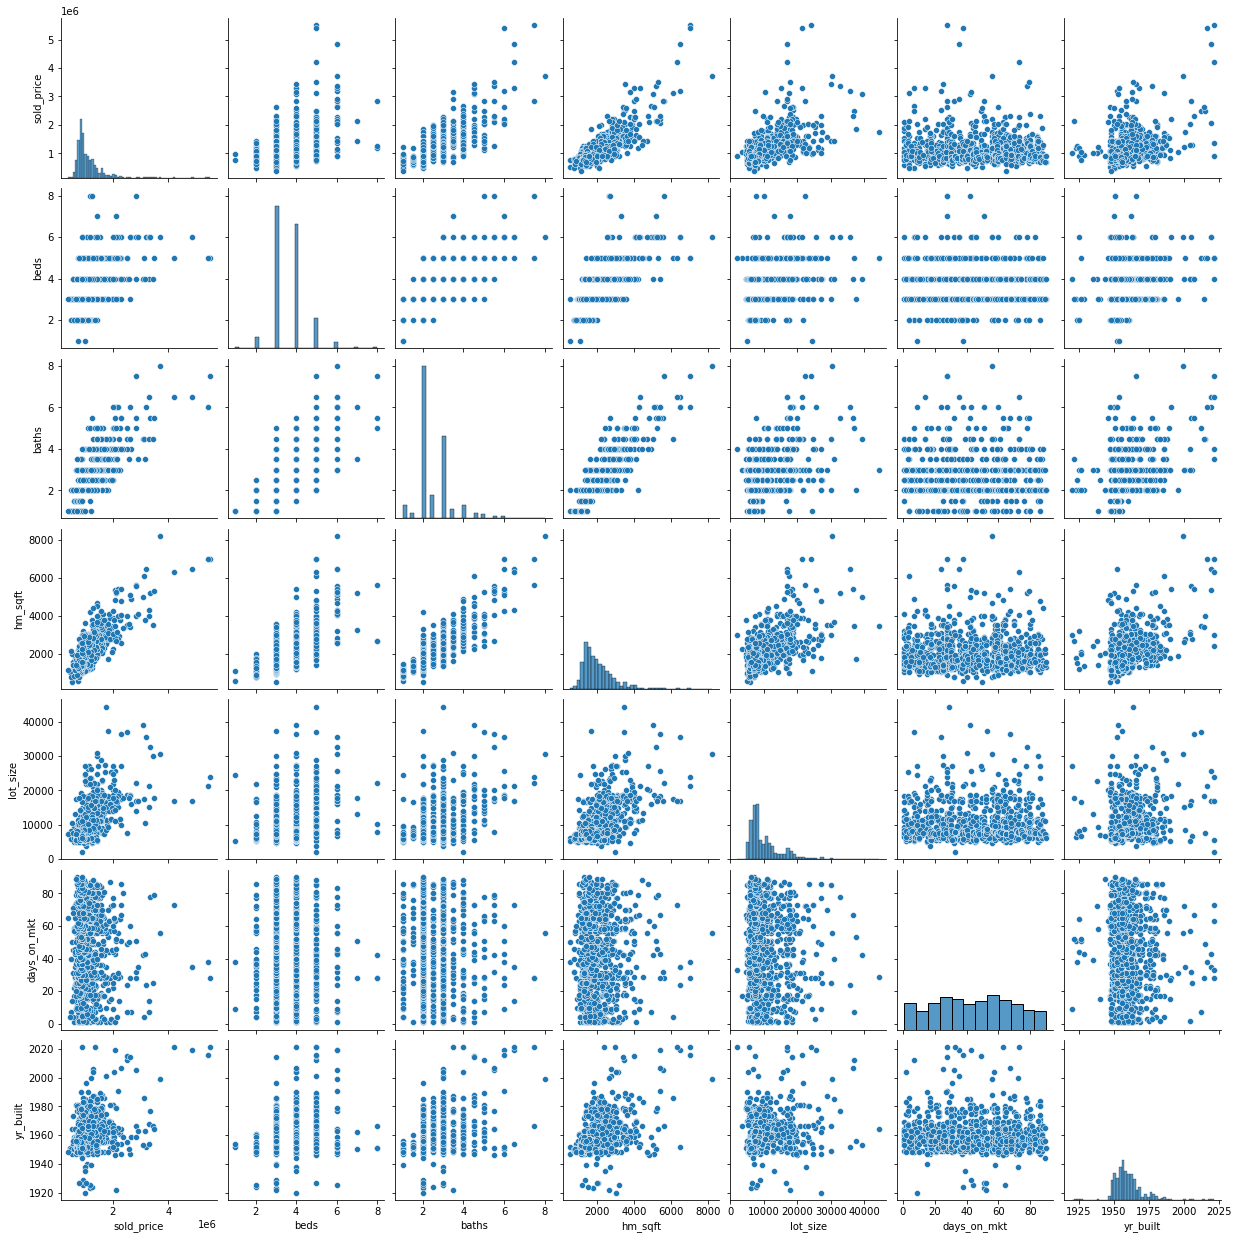

In [11]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'days_on_mkt', 'yr_built']);

In [12]:
df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']].corr()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,days_on_mkt
sold_price,1.000000,0.468586,0.747992,0.836873,0.616309,0.405557,-0.015035
beds,0.468586,1.000000,0.677780,0.673701,0.353676,0.330157,-0.003969
baths,0.747992,0.677780,1.000000,0.853740,0.506800,0.425517,-0.003983
hm_sqft,0.836873,0.673701,0.853740,1.000000,0.611860,0.482993,-0.012386
lot_size,0.616309,0.353676,0.506800,0.611860,1.000000,0.235796,-0.011387
yr_built,0.405557,0.330157,0.425517,0.482993,0.235796,1.000000,-0.031676
days_on_mkt,-0.015035,-0.003969,-0.003983,-0.012386,-0.011387,-0.031676,1.000000


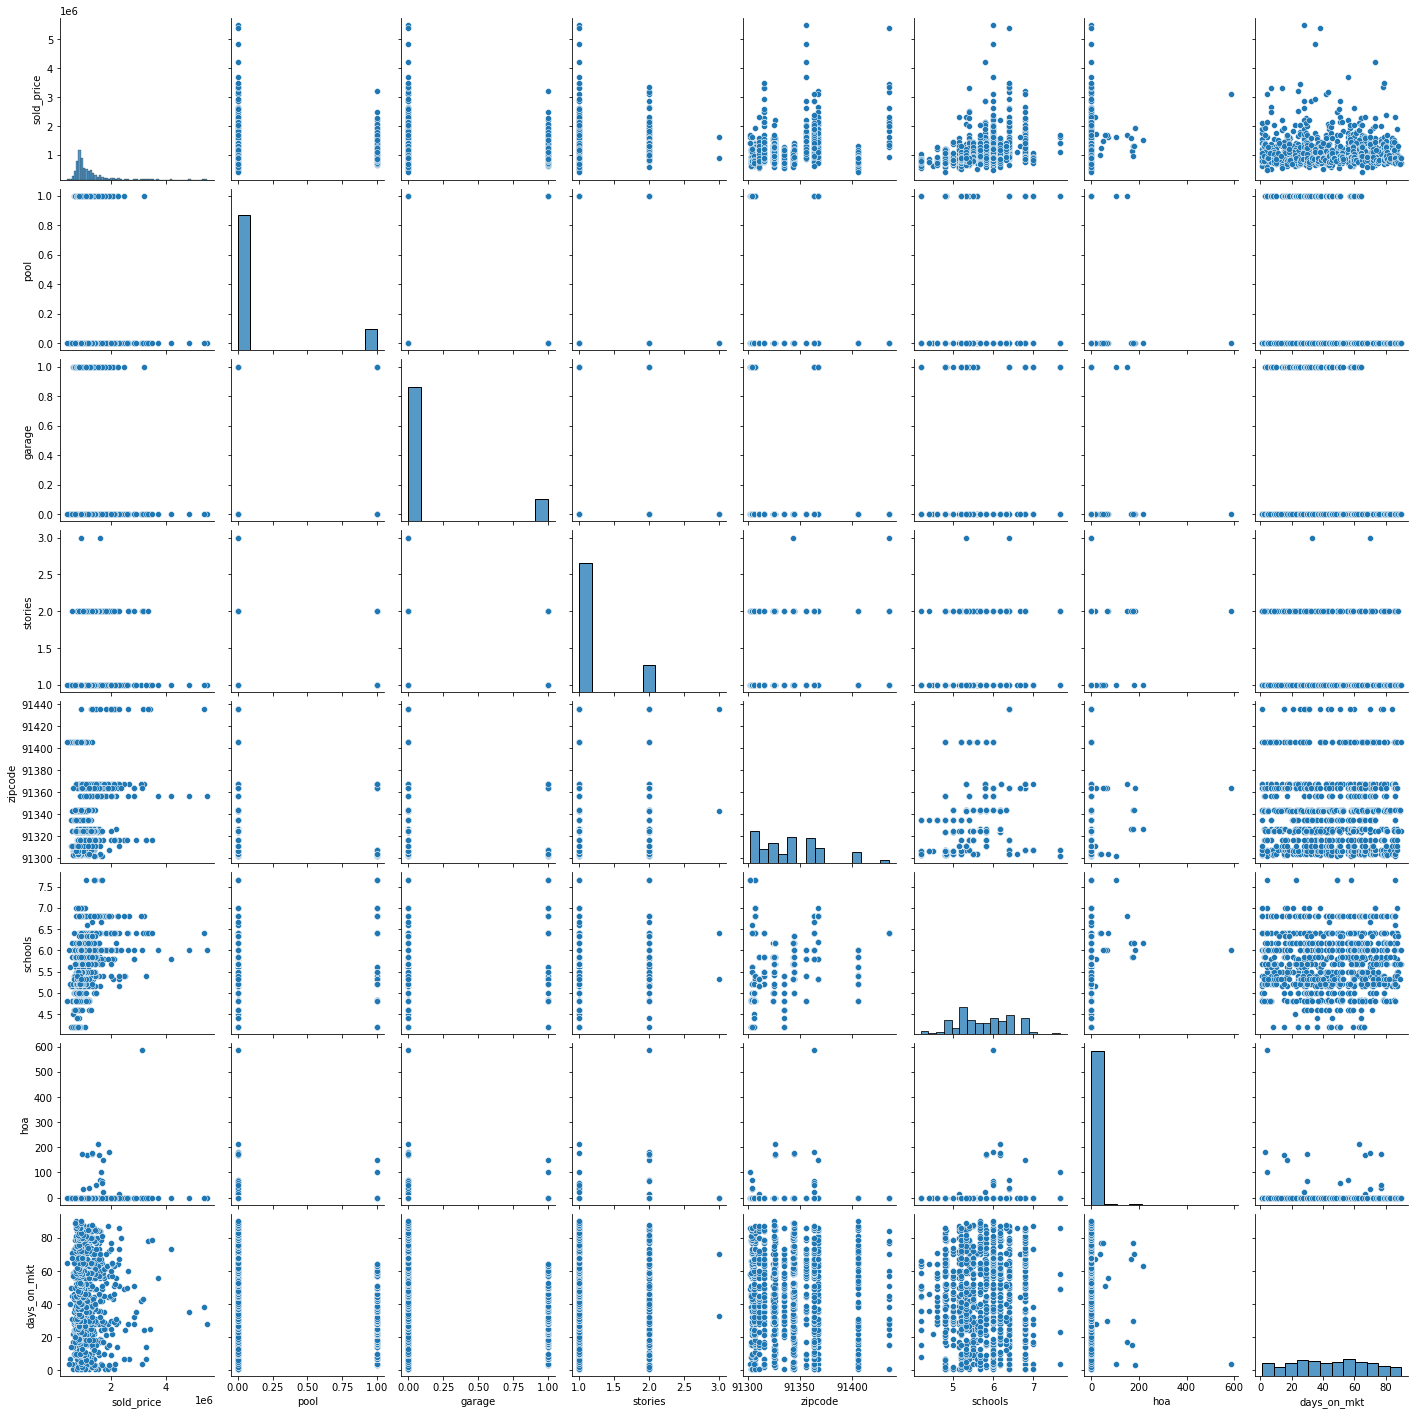

In [13]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']);

In [14]:
df[['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']].corr()

,sold_price,pool,garage,stories,zipcode,schools,hoa,days_on_mkt
sold_price,1.000000,0.028298,0.025144,0.187080,0.219329,0.356463,0.143552,-0.015035
pool,0.028298,1.000000,0.950247,0.074175,-0.100235,0.268048,-0.009247,-0.219170
garage,0.025144,0.950247,1.000000,0.057655,-0.096038,0.280840,-0.010762,-0.225222
stories,0.187080,0.074175,0.057655,1.000000,-0.028739,0.177494,0.136809,-0.051873
zipcode,0.219329,-0.100235,-0.096038,-0.028739,1.000000,0.267983,0.006319,-0.012574
schools,0.356463,0.268048,0.280840,0.177494,0.267983,1.000000,0.061756,-0.026134
hoa,0.143552,-0.009247,-0.010762,0.136809,0.006319,0.061756,1.000000,-0.042238
days_on_mkt,-0.015035,-0.219170,-0.225222,-0.051873,-0.012574,-0.026134,-0.042238,1.000000


#### Early conclusion: days_on_mkt (and alternative target) is uniformly distributed & pretty much uncorrelated w/ everything else!

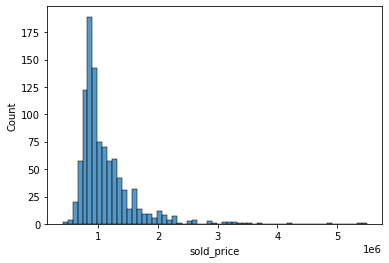

In [15]:
sns.histplot(data=df['sold_price']);

#### Perhaps log transforming the target can lead to a better model

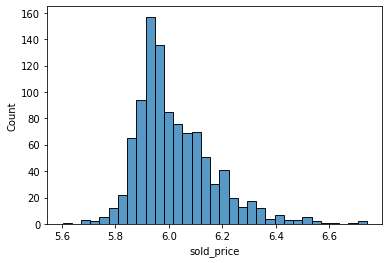

In [16]:
sns.histplot(data=np.log10(df['sold_price']));

# 2) Feature Engineering (part 1)

### Given the high VIFs with 1-hot zips, let's try grouping zipcodes into 'cities' and 1-hot that instead

In [17]:
df_data = df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 
              'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa']]

In [18]:
df_data['zipcode'].dtype

dtype('int64')

In [19]:
df_data['city'] = df_data['zipcode'].map({91302: 'woodland_hills',
                                          91303: 'canoga_park',
                                          91304: 'canoga_park',
                                          91306: 'winnetka',
                                          91307: 'west_hills',
                                          91311: 'chatsworth',
                                          91316: 'encino',
                                          91324: 'northridge',
                                          91325: 'northridge',
                                          91326: 'porter_ranch',
                                          91335: 'reseda',
                                          91343: 'north_hills',
                                          91344: 'granada_hills',
                                          91356: 'tarzana',
                                          91364: 'woodland_hills',
                                          91367: 'woodland_hills',
                                          91406: 'lake_balboa',
                                          91436: 'encino'}
                                        )

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/3655593410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['city'] = df_data['zipcode'].map({91302: 'woodland_hills',


In [20]:
df_data.drop(columns='zipcode')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sold_price  1010 non-null   int64  
 1   beds        1010 non-null   int64  
 2   baths       1010 non-null   float64
 3   hm_sqft     1010 non-null   int64  
 4   lot_size    1010 non-null   int64  
 5   yr_built    1010 non-null   int64  
 6   pool        1010 non-null   int64  
 7   garage      1010 non-null   int64  
 8   stories     1010 non-null   int64  
 9   zipcode     1010 non-null   int64  
 10  schools     1010 non-null   float64
 11  hoa         1010 non-null   int64  
 12  city        1010 non-null   object 
dtypes: float64(2), int64(10), object(1)
memory usage: 102.7+ KB


In [21]:
df_data = pd.get_dummies(df_data, columns=['city'], drop_first=True)
df_data.drop(columns='zipcode', inplace=True)

### Change 'stories' to binary variable 'one_story' (1 = yes, 0 = no => multi-story)

In [22]:
df_data['stories'].value_counts()

1    833
2    175
3      2
Name: stories, dtype: int64

In [23]:
df_data.loc[df_data['stories'] > 1, 'stories'] = 0
df_data.rename(columns={'stories': 'one_story'}, inplace=True)
df_data.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,one_story,schools,hoa,city_chatsworth,city_encino,city_granada_hills,city_lake_balboa,city_north_hills,city_northridge,city_porter_ranch,city_reseda,city_tarzana,city_west_hills,city_winnetka,city_woodland_hills
0,970000,4,3.0,1933,6999,1960,1,1,1,6.4,0,0,0,0,0,0,0,0,0,0,0,0,1
1,900000,3,2.0,1519,11761,1974,1,1,1,6.4,0,0,0,0,0,0,0,0,0,0,0,0,0
2,830000,3,2.0,1595,10560,1960,1,1,1,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0
3,820000,3,2.5,1364,7253,1959,0,0,1,7.0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,940553,4,2.5,2018,9347,1960,1,1,1,6.8,0,0,0,0,0,0,0,0,0,0,0,0,1


In [24]:
df_data['one_story'].value_counts()

1    833
0    177
Name: one_story, dtype: int64

# 3) Baseline Features for Modeling

#### Define a Diagnostic Plot Function 
##### (adapted from func of same name provided in Metis linear assumptions & testing notebook)

In [178]:
def diagnostic_plots(x, y, y_pred):    
    
    plt.figure(figsize=(20,5))
    plt.tight_layout(pad=10.0)
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.plot([0, 3.5e6], [0, 3.5e6], color='r', linestyle='--')
    plt.title('Pred. vs. True Sale Price', fontweight='bold', size=18)
    plt.xlabel("Predicted", fontweight='bold', size=16)
    plt.ylabel("True Sale Price", fontweight='bold', size=16)
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title("Residuals plot", fontweight='bold', size=18)
    plt.xlabel("Predicted", fontweight='bold', size=16)
    plt.ylabel("Residual", fontweight='bold', size=16)
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot", fontweight='bold', size=18)
    plt.xlabel('Theoretical Quantiles', fontweight='bold', size=16)
    plt.ylabel('Ordered Values', fontweight='bold', size=16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')

In [26]:
def cv_rsquareds(x, y, model, cv):    
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('CV R-squareds: {}'.format(scores)) 
    print('Mean CV R-squared: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))
    
    n = x.shape[0]
    p = x.shape[1]
    adj_r_squareds = [round(1 - (1 - r_squared)*((n - 1)/(n - p - 1)), 3) for r_squared in scores]
    print('\nAdjusted CV R-squareds: {}'.format(adj_r_squareds))
    print('Mean Adjusted CV R-squared: {} +/- {}'.format(round(np.mean(adj_r_squareds), 3), 
                                                         round(np.std(adj_r_squareds), 3)))

In [27]:
def cv_maes(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv)
    scores = [round(val) for val in scores]
    
    print('\nCV MAEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV MAE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

In [200]:
def cv_rmse(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cv)
    scores = [round(-np.sqrt(-val)) for val in scores]
    
    print('\nCV RMSEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV RMSE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

### Split into CV and Test Sets (will NOT touch Test set until final model has been chosen and tuned!)

In [195]:
X = df_data.drop(columns='sold_price')
y = df_data['sold_price']

In [196]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model 1: Linear Model, all features

In [201]:
model_1 = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1, 5)
cv_maes(X_cv, y_cv, model_1, 5)
cv_rmse(X_cv, y_cv, model_1, 5)

CV R-squareds: [0.802, 0.824, 0.844, 0.842, 0.832]
Mean CV R-squared: 0.829 +/- 0.015

Adjusted CV R-squareds: [0.797, 0.819, 0.84, 0.838, 0.828]
Mean Adjusted CV R-squared: 0.824 +/- 0.016

CV MAEs: [154332, 125059, 125116, 134704, 140473]
Mean CV MAE: 135937 +/- 10917

CV RMSEs: [250516, 167986, 182744, 194349, 184580]
Mean CV RMSE: 196035 +/- 28515


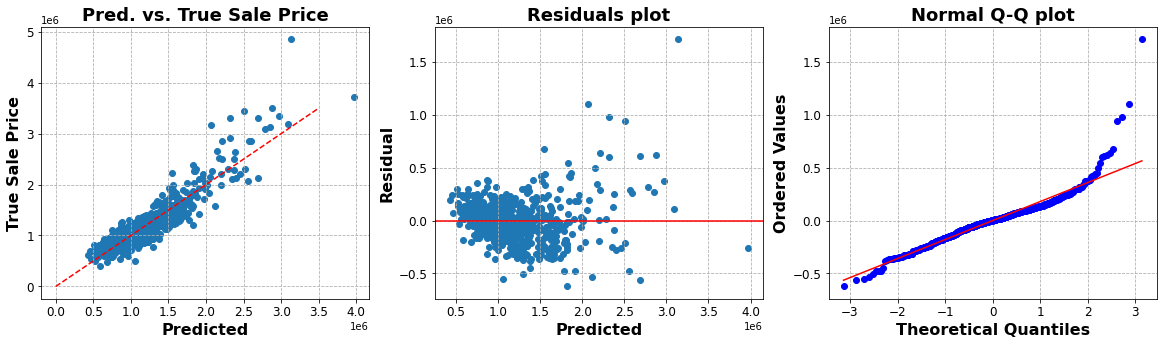

In [179]:
model_1.fit(X_cv, y_cv)

y_pred = model_1.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

#### Are the two highest priced predictions  influential points? Let's refit this using statsmodels to find out:

In [32]:
x_cv = sm.add_constant(X_cv)
model = sm.OLS(y_cv, x_cv)
model_1b = model.fit()
model_1b.summary()

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     191.3
Date:                Fri, 10 Sep 2021   Prob (F-statistic):          2.15e-297
Time:                        03:43:27   Log-Likelihood:                -10963.
No. Observations:                 808   AIC:                         2.197e+04
Df Residuals:                     785   BIC:                         2.208e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -3.03e+06   1.43e+06     -2.123      0.034   -5.83e+06   -2.29e+05
beds                -3.278e+04   1.22e+04     -2.685      0.007   -5.67e+04   -8812.498
baths                8.053e+04   1.49e+04      5.423      0.000    5.14e+04     1.1e+05
hm_sqft               298.7515     17.744     16.837      0.000     263.920     333.583
lot_size               16.7642      1.740      9.637      0.000      13.349      20.179
yr_built             1335.3050    735.115      1.816      0.070    -107.719    2778.330
pool                -3.874e+04   6.63e+04     -0.584      0.559   -1.69e+05    9.15e+04
garage               2.817e+04   6.55e+04      0.430      0.667      -1e+05    1.57e+05
one_story            1.128e+05   2.05e+04      5.509      0.000    7.26e+04    1.53e+05
schools              9.402e+04   1.59e+04      5.923      0.000    6.29e+04    1.25e+05
hoa                   486.8420    255.935      1.902      0.058     -15.556     989.240
city_chatsworth     -1.704e+05   4.24e+04     -4.015      0.000   -2.54e+05   -8.71e+04
city_encino           4.13e+05   3.84e+04     10.756      0.000    3.38e+05    4.88e+05
city_granada_hills  -8.409e+04   3.32e+04     -2.535      0.011   -1.49e+05    -1.9e+04
city_lake_balboa     5748.8843   3.53e+04      0.163      0.871   -6.36e+04    7.51e+04
city_north_hills    -1.061e+05   3.75e+04     -2.827      0.005    -1.8e+05   -3.24e+04
city_northridge     -9.307e+04   3.65e+04     -2.553      0.011   -1.65e+05   -2.15e+04
city_porter_ranch   -7.731e+04   3.97e+04     -1.949      0.052   -1.55e+05     561.999
city_reseda           5.76e+04   3.71e+04      1.553      0.121   -1.52e+04     1.3e+05
city_tarzana         2.501e+05   4.37e+04      5.724      0.000    1.64e+05    3.36e+05
city_west_hills     -7.608e+04   3.82e+04     -1.991      0.047   -1.51e+05   -1072.792
city_winnetka       -4639.5865   4.42e+04     -0.105      0.916   -9.15e+04    8.22e+04
city_woodland_hills   6.69e+04   3.36e+04      1.988      0.047     852.493    1.33e+05
==============================================================================
Omnibus:                      330.048   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4567.472
Skew:                           1.458   Prob(JB):                         0.00
Kurtosis:                      14.277   Cond. No.                     2.54e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
influence_frame = model_1b.get_influence().summary_frame()
influence_frame['cooks_d'].sort_values(ascending=False).head()

468    0.410261
413    0.287325
695    0.051864
692    0.047180
414    0.034331
Name: cooks_d, dtype: float64

##### Technically, no influence points (Cook's dist > 0.5), but as suspected, largest Cook's distances are all for sale prices > 3e6

In [34]:
print(y_cv.loc[468])
print(y_cv.loc[413])
print(y_cv.loc[695])
print(y_cv.loc[692])

4850000
3125000
3162000
3445000


In [35]:
df_data['sold_price'].describe()

count    1.010000e+03
mean     1.125490e+06
std      5.020166e+05
min      4.000000e+05
25%      8.400000e+05
50%      9.650000e+05
75%      1.260000e+06
max      5.500000e+06
Name: sold_price, dtype: float64

In [36]:
df[df_data['sold_price'] < 575000].shape[0]

6

In [37]:
df_data[df_data['sold_price'] >= 3e6].shape[0]

14

In [38]:
df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]['sold_price'].describe()

count    9.900000e+02
mean     1.091561e+06
std      3.782013e+05
min      5.750000e+05
25%      8.400000e+05
50%      9.600000e+05
75%      1.250000e+06
max      2.919500e+06
Name: sold_price, dtype: float64

##### Command decision: 'sold_price' >= 3 million is almost 4-sigma from the mean, so let's just drop the 14 >= 3 million dollar homes
##### AND, 'sold_price" < 575k is even further from the mean than that, so let's also drop the 6 < 575k dollar homes
##### (i.e. This model is geared towards the much more common lower home prices, not the handful of very high-priced homes, and it's also
#####  geared toward those that have a "realistic" lower bound on prices - e.g., not something that's a teardown, former meth house, etc.)

#### While we're here, what about colinearity (VIF)?

In [39]:
variables = model_1b.model.exog

# Don't count the intercept! (index=0)
vifs = [variance_inflation_factor(variables, i) for i in range(1, variables.shape[1])]
list(zip(X_cv.columns, vifs))

[('beds', 2.3148128749207326),
 ('baths', 4.043471517332343),
 ('hm_sqft', 5.388832661032012),
 ('lot_size', 1.804812618293314),
 ('yr_built', 1.5541937438842295),
 ('pool', 11.55709054017307),
 ('garage', 11.693702898655935),
 ('one_story', 1.343850740615704),
 ('schools', 2.510301883327543),
 ('hoa', 1.0934388039308098),
 ('city_chatsworth', 1.4612584697994708),
 ('city_encino', 2.1620786184485126),
 ('city_granada_hills', 2.3727980763444694),
 ('city_lake_balboa', 1.9428917929050251),
 ('city_north_hills', 1.7670036533211684),
 ('city_northridge', 1.8548367675667148),
 ('city_porter_ranch', 2.009986217982023),
 ('city_reseda', 1.692616002511555),
 ('city_tarzana', 1.645057586080708),
 ('city_west_hills', 1.9691722555592364),
 ('city_winnetka', 1.3905932150645586),
 ('city_woodland_hills', 4.226194025443885)]

#### Note that the previous VIFs for the 'zipcode' 1-hots were way worse than these for the 'city' 1-hots!

In [40]:
df_data[['pool', 'garage']].corr()

,pool,garage
pool,1.000000,0.950247
garage,0.950247,1.000000


In [41]:
df_data[['pool', 'garage']].value_counts()

pool  garage
0     0         865
1     1         133
0     1           9
1     0           3
dtype: int64

#### Aha! 'pool' & 'garage' are highly correlated (missed that in the pair plots); let's drop 'pool'

In [42]:
df_data = df_data.drop(columns='pool')

In [43]:
df_data.columns

Index(['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built',
       'garage', 'one_story', 'schools', 'hoa', 'city_chatsworth',
       'city_encino', 'city_granada_hills', 'city_lake_balboa',
       'city_north_hills', 'city_northridge', 'city_porter_ranch',
       'city_reseda', 'city_tarzana', 'city_west_hills', 'city_winnetka',
       'city_woodland_hills'],
      dtype='object')

#### Pare down the dataset (dropping extreme low and extreme high prices) and rebuild the model

In [202]:
X = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')
y = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]['sold_price']

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [203]:
model_1c = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1c, 5)
cv_maes(X_cv, y_cv, model_1c, 5)
cv_rmse(X_cv, y_cv, model_1c, 5)

CV R-squareds: [0.815, 0.862, 0.824, 0.799, 0.791]
Mean CV R-squared: 0.818 +/- 0.025

Adjusted CV R-squareds: [0.81, 0.858, 0.819, 0.794, 0.785]
Mean Adjusted CV R-squared: 0.813 +/- 0.025

CV MAEs: [116397, 103985, 120798, 117580, 124566]
Mean CV MAE: 116665 +/- 6945

CV RMSEs: [161992, 137149, 165857, 165980, 168778]
Mean CV RMSE: 159951 +/- 11604


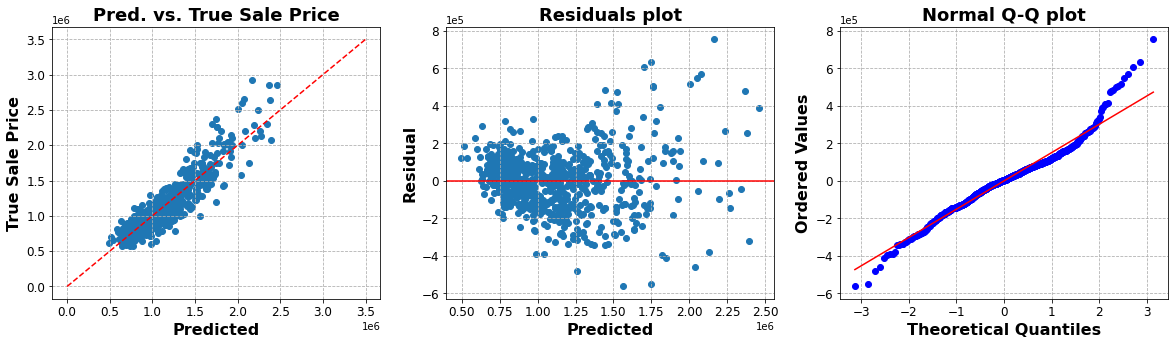

In [204]:
model_1c.fit(X_cv, y_cv)

y_pred = model_1c.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

### Model 2: Let's move to polynomial regression from here on

In [205]:
X2 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X2_cv, X2_test, y2_cv, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X2_cv = poly.fit_transform(X2_cv)

# Apply polynomial transformation to test set
X2_test = poly.transform(X2_test)

In [206]:
len(poly.get_feature_names())

253

In [207]:
model_2 = LinearRegression()

cv_rsquareds(X2_cv, y2_cv, model_2, 5)
cv_maes(X2_cv, y2_cv, model_2, 5)
cv_rmse(X2_cv, y2_cv, model_2, 5)

CV R-squareds: [0.515, -41.035, -6.318, 0.66, 0.71]
Mean CV R-squared: -9.094 +/- 16.196

Adjusted CV R-squareds: [0.287, -60.802, -9.759, 0.5, 0.574]
Mean Adjusted CV R-squared: -13.84 +/- 23.812

CV MAEs: [139661, 462368, 243626, 156395, 132404]
Mean CV MAE: 226891 +/- 124287

CV RMSEs: [261955, 2390105, 1069152, 215891, 198961]
Mean CV RMSE: 827213 +/- 847242


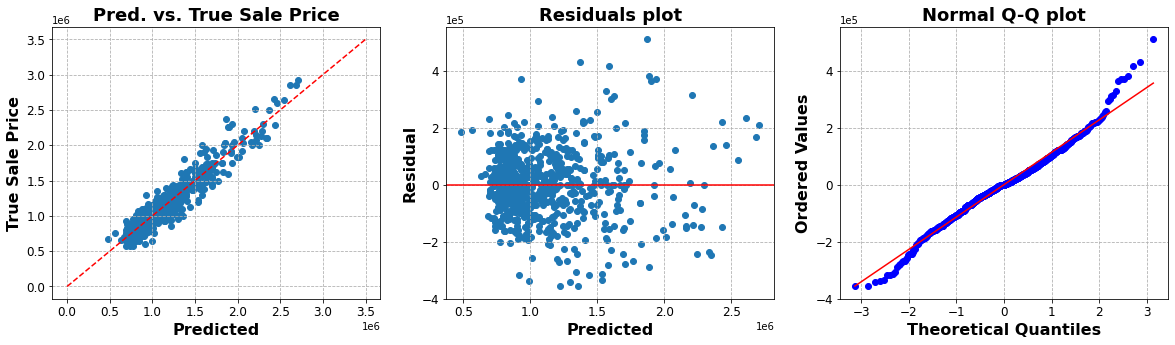

In [208]:
model_2.fit(X2_cv, y2_cv)

y2_pred = model_2.predict(X2_cv)

diagnostic_plots(X2_cv, y2_cv, y2_pred)

### Model 3: Try "Lazy" Lasso (specifically to eliminate some predictors)

In [209]:
X3 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X3_cv = poly.fit_transform(X3_cv)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [77]:
alphas = 10**np.linspace(3, 5, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=800000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 2694.2


In [210]:
model_3 = Lasso(alpha=2694.2, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)
cv_rmse(X3_cv_scaled, y3_cv, model_3, 5)

CV R-squareds: [0.835, 0.876, 0.878, 0.827, 0.799]
Mean CV R-squared: 0.843 +/- 0.03

Adjusted CV R-squareds: [0.757, 0.818, 0.821, 0.746, 0.704]
Mean Adjusted CV R-squared: 0.769 +/- 0.045

CV MAEs: [105972, 95784, 101571, 108882, 119021]
Mean CV MAE: 106246 +/- 7766

CV RMSEs: [153061, 129885, 137886, 153849, 165544]
Mean CV RMSE: 148045 +/- 12634


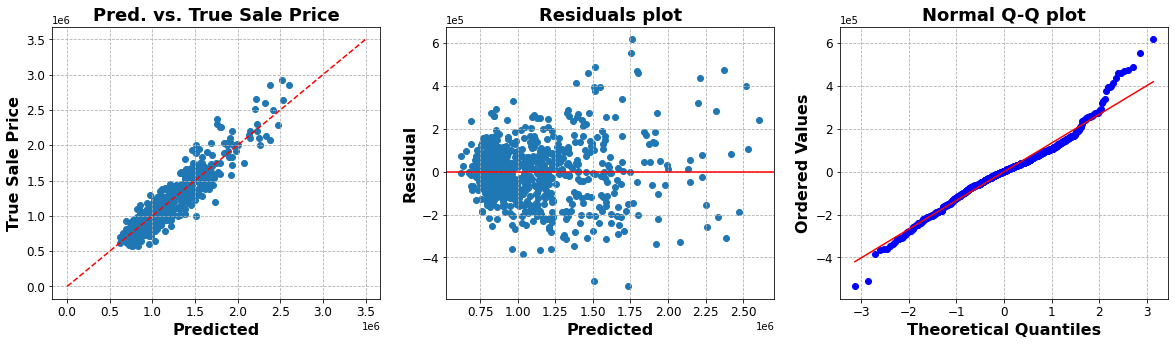

In [211]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, y3_cv, y3_pred)

In [85]:
temp = [val for val in list(zip(poly.get_feature_names(), model_3.coef_)) if val[1] != 0.0]
temp

[('x4', 865.5000654840052),
 ('x12', 13.21910003742853),
 ('x0 x12', 1401.4893401423685),
 ('x1 x2', 23098.294070110467),
 ('x1 x3', 53236.226378757805),
 ('x1 x7', 6492.267856437005),
 ('x1 x9', -10098.265777671311),
 ('x2 x7', 178114.15388431182),
 ('x2 x10', 86220.98264256529),
 ('x2 x11', -12300.698204133983),
 ('x2 x13', -20476.892091841775),
 ('x2 x16', 5946.722136728736),
 ('x2 x17', 26148.33354172867),
 ('x2 x19', -5287.3070053403235),
 ('x2 x20', 23110.523280263053),
 ('x3^2', -28647.365867755743),
 ('x3 x6', 21427.50362976337),
 ('x3 x7', 43761.003207726724),
 ('x3 x10', 19798.120604490436),
 ('x3 x20', 39469.98019693602),
 ('x5 x6', 2067.3679704588667),
 ('x5 x8', 2550.0584146250735),
 ('x5 x18', -3664.435520445827),
 ('x6 x8', 1260.0048813395967),
 ('x6 x15', -4603.609477620926),
 ('x7 x17', 39147.16762163755),
 ('x7 x18', -6438.706613809951),
 ('x8 x9', 7456.767491145067),
 ('x8 x11', 402.06460960900284),
 ('x8 x20', 3209.4368431417074),
 ('x12^2', 3101.2501058617177)]

In [108]:
temp2 = [val[0].replace('x', '') for val in temp]

In [109]:
temp3 = [val.replace(' ', '*').replace('^', '**') for val in temp2]

In [159]:
results = []
for val in temp3:
    if '**' in val:
        results.append(X3.columns[int(val.split('**')[0])] + '_SQ')
    elif '*' in val:
        results.append(X3.columns[int(val.split('*')[0])] + '_X_' + X3.columns[int(val.split('*')[1])])
    else:
        results.append(X3.columns[int(val)])
results

['yr_built',
 'city_lake_balboa',
 'beds_X_city_lake_balboa',
 'baths_X_hm_sqft',
 'baths_X_lot_size',
 'baths_X_schools',
 'baths_X_city_chatsworth',
 'hm_sqft_X_schools',
 'hm_sqft_X_city_encino',
 'hm_sqft_X_city_granada_hills',
 'hm_sqft_X_city_north_hills',
 'hm_sqft_X_city_reseda',
 'hm_sqft_X_city_tarzana',
 'hm_sqft_X_city_winnetka',
 'hm_sqft_X_city_woodland_hills',
 'lot_size_SQ',
 'lot_size_X_one_story',
 'lot_size_X_schools',
 'lot_size_X_city_encino',
 'lot_size_X_city_woodland_hills',
 'garage_X_one_story',
 'garage_X_hoa',
 'garage_X_city_west_hills',
 'one_story_X_hoa',
 'one_story_X_city_porter_ranch',
 'schools_X_city_tarzana',
 'schools_X_city_west_hills',
 'hoa_X_city_chatsworth',
 'hoa_X_city_granada_hills',
 'hoa_X_city_woodland_hills',
 'city_lake_balboa_SQ']

#### Re-run Lasso using just the terms above

In [212]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X3 = temp_df[['yr_built','city_lake_balboa']]

X3['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X3['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
X3['baths_X_lot_size'] = temp_df['baths'] * temp_df['lot_size']
X3['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X3['baths_X_city_chatsworth'] = temp_df['baths'] * temp_df['city_chatsworth']
X3['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X3['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X3['hm_sqft_X_city_granada_hills'] = temp_df['hm_sqft'] * temp_df['city_granada_hills']
X3['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X3['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X3['hm_sqft_X_city_tarzana'] = temp_df['hm_sqft'] * temp_df['city_tarzana']
X3['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X3['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X3['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X3['lot_size_X_schools'] = temp_df['lot_size'] * temp_df['schools']
X3['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X3['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X3['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X3['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X3['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X3['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X3['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X3['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X3['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X3['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X3['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X3['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X3['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']
X3['city_lake_balboa_SQ'] = temp_df['city_lake_balboa'] * temp_df['city_lake_balboa']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/1037111964.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/1037111964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/1037111964.py:6: SettingWithCopyWarning: 
A value i

In [213]:
X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [167]:
alphas = 10**np.linspace(3, 5, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=800000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 1000.0


In [215]:
model_3 = Lasso(alpha=1000.0, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)
cv_rmse(X3_cv_scaled, y3_cv, model_3, 5)

CV R-squareds: [0.852, 0.88, 0.88, 0.827, 0.808]
Mean CV R-squared: 0.849 +/- 0.029

Adjusted CV R-squareds: [0.846, 0.875, 0.875, 0.82, 0.8]
Mean Adjusted CV R-squared: 0.843 +/- 0.03

CV MAEs: [101343, 95431, 100685, 108234, 117277]
Mean CV MAE: 104594 +/- 7535

CV RMSEs: [144972, 127853, 136683, 154012, 161577]
Mean CV RMSE: 145019 +/- 11993


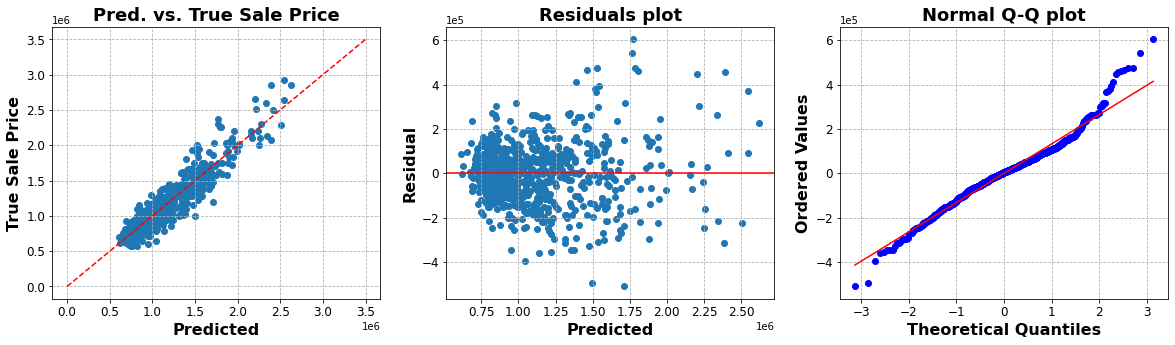

In [216]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, y3_cv, y3_pred)

#### We can now take just terms above, manually form them into the data and rerun a normal linear reg (model 2)

### Model 2b: Unregularized Linear Regression Again (on just the Lasso-selected variables)

In [217]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X2b = temp_df[['yr_built','city_lake_balboa']]

X2b['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X2b['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
X2b['baths_X_lot_size'] = temp_df['baths'] * temp_df['lot_size']
X2b['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X2b['baths_X_city_chatsworth'] = temp_df['baths'] * temp_df['city_chatsworth']
X2b['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X2b['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X2b['hm_sqft_X_city_granada_hills'] = temp_df['hm_sqft'] * temp_df['city_granada_hills']
X2b['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X2b['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X2b['hm_sqft_X_city_tarzana'] = temp_df['hm_sqft'] * temp_df['city_tarzana']
X2b['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X2b['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X2b['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X2b['lot_size_X_schools'] = temp_df['lot_size'] * temp_df['schools']
X2b['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X2b['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X2b['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X2b['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X2b['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X2b['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X2b['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X2b['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X2b['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X2b['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X2b['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X2b['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X2b['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']
X2b['city_lake_balboa_SQ'] = temp_df['city_lake_balboa'] * temp_df['city_lake_balboa']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/2595155645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2b['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/2595155645.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2b['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/2595155645.py:6: SettingWithCopyWarning: 
A value

In [162]:
X2b.head()

,yr_built,city_lake_balboa,beds_X_city_lake_balboa,baths_X_hm_sqft,baths_X_lot_size,baths_X_schools,baths_X_city_chatsworth,hm_sqft_X_schools,hm_sqft_X_city_encino,hm_sqft_X_city_granada_hills,hm_sqft_X_city_north_hills,hm_sqft_X_city_reseda,hm_sqft_X_city_tarzana,hm_sqft_X_city_winnetka,hm_sqft_X_city_woodland_hills,lot_size_X_one_story,lot_size_X_schools,lot_size_X_city_encino,lot_size_X_city_woodland_hills,garage_X_one_story,garage_X_hoa,garage_X_city_west_hills,one_story_X_hoa,one_story_X_city_porter_ranch,schools_X_city_tarzana,schools_X_city_west_hills,hoa_X_city_chatsworth,hoa_X_city_granada_hills,hoa_X_city_woodland_hills,lot_size_SQ,city_lake_balboa_SQ
0,1960,0,0,5799.0,20997.0,19.2,0.0,12371.2,0,0,0,0,0,0,1933,6999,44793.6,0,6999,1,0,0,0,0,0.0,0.0,0,0,0,48986001,0
1,1974,0,0,3038.0,23522.0,12.8,0.0,9721.6,0,0,0,0,0,0,0,11761,75270.4,0,0,1,0,0,0,0,0.0,0.0,0,0,0,138321121,0
2,1960,0,0,3190.0,21120.0,9.6,0.0,7656.0,0,0,0,0,0,0,0,10560,50688.0,0,0,1,0,0,0,0,0.0,0.0,0,0,0,111513600,0
3,1959,0,0,3410.0,18132.5,17.5,0.0,9548.0,0,0,0,0,0,0,0,7253,50771.0,0,0,0,0,0,0,0,0.0,7.0,0,0,0,52606009,0
4,1960,0,0,5045.0,23367.5,17.0,0.0,13722.4,0,0,0,0,0,0,2018,9347,63559.6,0,9347,1,0,0,0,0,0.0,0.0,0,0,0,87366409,0


In [218]:
X2b_cv, X2b_test, y2b_cv, y2b_test = train_test_split(X2b, y, test_size=0.2, random_state=42)

In [219]:
model_2b = LinearRegression()

cv_rsquareds(X2b_cv, y2b_cv, model_2b, 5)
cv_maes(X2b_cv, y2b_cv, model_2b, 5)
cv_rmse(X2b_cv, y2b_cv, model_2b, 5)

CV R-squareds: [0.855, 0.879, 0.876, 0.824, 0.804]
Mean CV R-squared: 0.848 +/- 0.029

Adjusted CV R-squareds: [0.849, 0.874, 0.871, 0.817, 0.796]
Mean Adjusted CV R-squared: 0.841 +/- 0.031

CV MAEs: [100414, 96442, 102748, 108555, 118429]
Mean CV MAE: 105318 +/- 7640

CV RMSEs: [143540, 128095, 139096, 155141, 163613]
Mean CV RMSE: 145897 +/- 12394


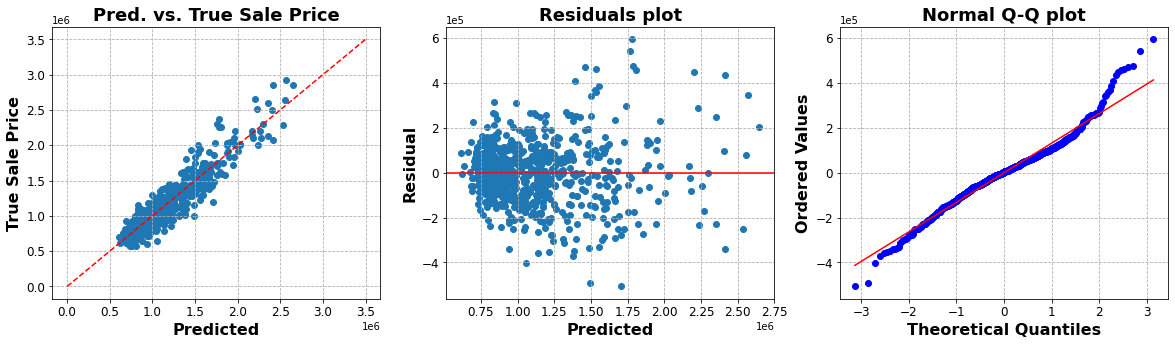

In [220]:
model_2b.fit(X2b_cv, y2b_cv)

y2b_pred = model_2b.predict(X2b_cv)

diagnostic_plots(X2b_cv, y2b_cv, y2b_pred)

### Model 4 - "Lazy" Ridge Regression (with just the Lasso-selected variables)

In [221]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X4 = temp_df[['yr_built','city_lake_balboa']]

X4['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X4['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
X4['baths_X_lot_size'] = temp_df['baths'] * temp_df['lot_size']
X4['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X4['baths_X_city_chatsworth'] = temp_df['baths'] * temp_df['city_chatsworth']
X4['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X4['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X4['hm_sqft_X_city_granada_hills'] = temp_df['hm_sqft'] * temp_df['city_granada_hills']
X4['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X4['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X4['hm_sqft_X_city_tarzana'] = temp_df['hm_sqft'] * temp_df['city_tarzana']
X4['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X4['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X4['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X4['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X4['lot_size_X_schools'] = temp_df['lot_size'] * temp_df['schools']
X4['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X4['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X4['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X4['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X4['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X4['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X4['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X4['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X4['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X4['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X4['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X4['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X4['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']
X4['city_lake_balboa_SQ'] = temp_df['city_lake_balboa'] * temp_df['city_lake_balboa']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/2588972312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X4['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/2588972312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X4['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/2588972312.py:6: SettingWithCopyWarning: 
A value i

In [222]:
X4_cv, X4_test, y4_cv, y4_test = train_test_split(X4, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X4_cv_scaled = scaler.fit_transform(X4_cv)

In [119]:
alphas = np.linspace(0.0001, 10000, 1000)
ridge_model = RidgeCV(alphas=alphas, cv=5, normalize=False)

ridge_model.fit(X4_cv_scaled, y4_cv)

alpha = round(ridge_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 30.03


In [223]:
model_4 = Ridge(alpha=30.03, max_iter=100000)

cv_rsquareds(X4_cv_scaled, y4_cv, model_4, 5)
cv_maes(X4_cv_scaled, y4_cv, model_4, 5)
cv_rmse(X4_cv_scaled, y4_cv, model_4, 5)

CV R-squareds: [0.848, 0.88, 0.878, 0.831, 0.823]
Mean CV R-squared: 0.852 +/- 0.023

Adjusted CV R-squareds: [0.842, 0.875, 0.873, 0.824, 0.816]
Mean Adjusted CV R-squared: 0.846 +/- 0.024

CV MAEs: [104454, 94042, 100863, 106072, 116047]
Mean CV MAE: 104296 +/- 7186

CV RMSEs: [146842, 127603, 137856, 151952, 155092]
Mean CV RMSE: 143869 +/- 10009


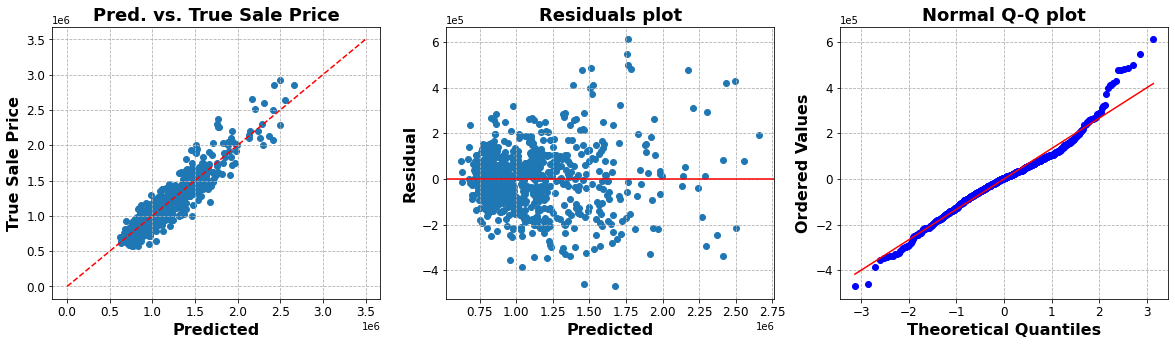

In [224]:
model_4.fit(X4_cv_scaled, y4_cv)

y4_pred = model_4.predict(X4_cv_scaled)

diagnostic_plots(X4_cv_scaled, y4_cv, y4_pred)

### Model 5 - "Lazy" ElasticNet Regression (with just Lasso-selected variables)

In [225]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X5 = temp_df[['yr_built','city_lake_balboa']]

X5['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X5['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
X5['baths_X_lot_size'] = temp_df['baths'] * temp_df['lot_size']
X5['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X5['baths_X_city_chatsworth'] = temp_df['baths'] * temp_df['city_chatsworth']
X5['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X5['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X5['hm_sqft_X_city_granada_hills'] = temp_df['hm_sqft'] * temp_df['city_granada_hills']
X5['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X5['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X5['hm_sqft_X_city_tarzana'] = temp_df['hm_sqft'] * temp_df['city_tarzana']
X5['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X5['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X5['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X5['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X5['lot_size_X_schools'] = temp_df['lot_size'] * temp_df['schools']
X5['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X5['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X5['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X5['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X5['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X5['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X5['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X5['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X5['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X5['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X5['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X5['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X5['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']
X5['city_lake_balboa_SQ'] = temp_df['city_lake_balboa'] * temp_df['city_lake_balboa']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/3412437389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/3412437389.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/3412437389.py:6: SettingWithCopyWarning: 
A value i

In [226]:
X5_cv, X5_test, y5_cv, y5_test = train_test_split(X5, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X5_cv_scaled = scaler.fit_transform(X5_cv)

In [130]:
alphas = [5.2, 5.3, 5.4, 5.5]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=1500000)

elastic_model.fit(X5_cv_scaled, y5_cv)

alpha = round(elastic_model.alpha_, 4)
print('Best alpha = {}'.format(alpha))
l1_ratio = round(elastic_model.l1_ratio_, 2)
print('Best L1 Ratio = {}'.format(l1_ratio))

Best alpha = 5.2
Best L1 Ratio = 0.99


In [227]:
model_5 = ElasticNet(alpha=5.2, l1_ratio=0.99, max_iter=1500000)

cv_rsquareds(X5_cv_scaled, y5_cv, model_5, 5)
cv_maes(X5_cv_scaled, y5_cv, model_5, 5)
cv_rmse(X5_cv_scaled, y5_cv, model_5, 5)

CV R-squareds: [0.847, 0.88, 0.878, 0.832, 0.824]
Mean CV R-squared: 0.852 +/- 0.023

Adjusted CV R-squareds: [0.841, 0.875, 0.873, 0.825, 0.817]
Mean Adjusted CV R-squared: 0.846 +/- 0.024

CV MAEs: [104649, 93959, 100803, 105971, 115882]
Mean CV MAE: 104253 +/- 7158

CV RMSEs: [147118, 127593, 137960, 151870, 154789]
Mean CV RMSE: 143866 +/- 9936


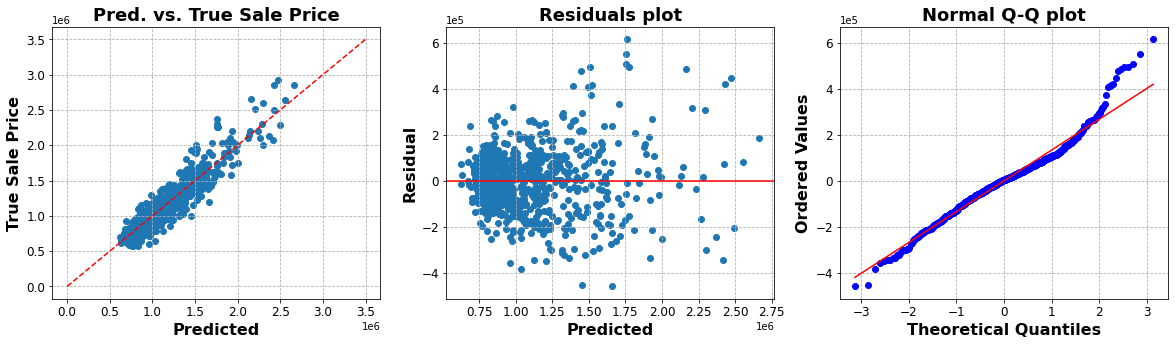

In [228]:
model_5.fit(X5_cv_scaled, y5_cv)

y5_pred = model_5.predict(X5_cv_scaled)

diagnostic_plots(X5_cv_scaled, y5_cv, y5_pred)

In [133]:
list(zip(X5_cv.columns, model_5.coef_))

[('yr_built', 8129.550315970252),
 ('city_lake_balboa', 2263.702911303784),
 ('beds_X_city_lake_balboa', 2540.267632858067),
 ('baths_X_hm_sqft', 51768.903240608954),
 ('baths_X_lot_size', 32610.26074588611),
 ('baths_X_schools', 21051.922226080194),
 ('baths_X_city_chatsworth', -12980.182263479794),
 ('hm_sqft_X_schools', 134363.6931113929),
 ('hm_sqft_X_city_encino', 75082.56332861308),
 ('hm_sqft_X_city_granada_hills', -13439.679367541603),
 ('hm_sqft_X_city_north_hills', -22351.70155256777),
 ('hm_sqft_X_city_reseda', 6830.000054117183),
 ('hm_sqft_X_city_tarzana', 31886.20861183812),
 ('hm_sqft_X_city_winnetka', -8570.179112728069),
 ('hm_sqft_X_city_woodland_hills', 31622.691250011696),
 ('lot_size_X_one_story', 25688.22816041551),
 ('lot_size_X_schools', 68009.39051211042),
 ('lot_size_X_city_encino', 32036.587027277925),
 ('lot_size_X_city_woodland_hills', 34166.659317937505),
 ('garage_X_one_story', 4520.162416347279),
 ('garage_X_hoa', 2680.623932284013),
 ('garage_X_city_wes

In [134]:
var_magnitudes = sorted(list(zip(X5_cv.columns, model_5.coef_)), key=lambda x: x[1])

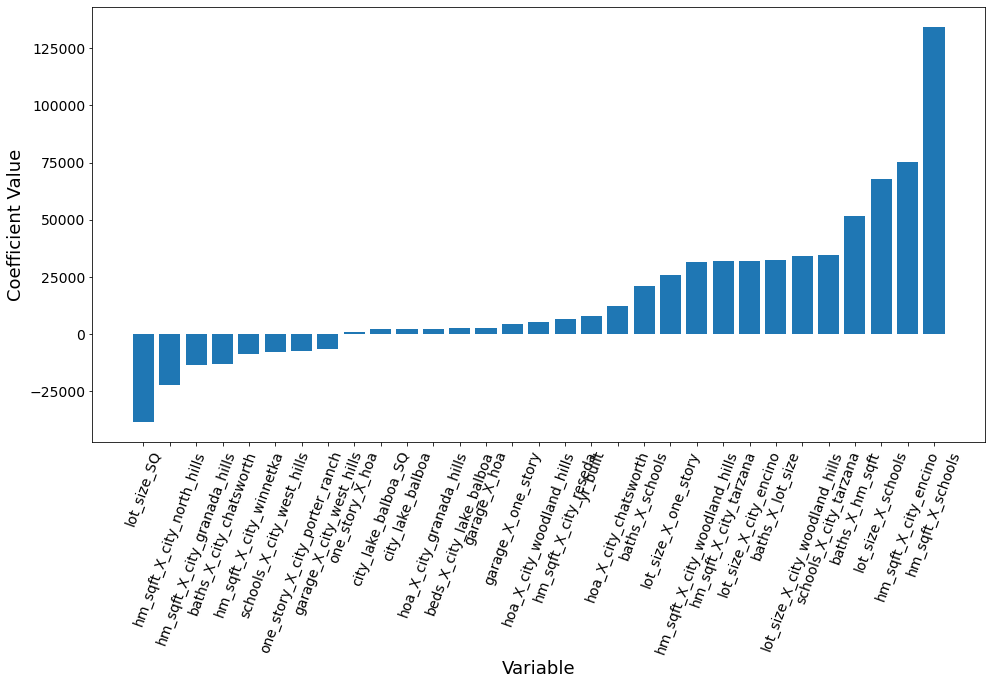

In [135]:
plt.figure(figsize=(16,8))
plt.bar(range(len(var_magnitudes)), [val[1] for val in var_magnitudes], align='center')
plt.xticks(range(len(var_magnitudes)), [val[0] for val in var_magnitudes])
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Variable', fontsize=18)
plt.ylabel('Coefficient Value', fontsize=18)
plt.show()

In [136]:
coeffs = [val[1] for val in list(zip(X5_cv.columns, model_5.coef_))]
pred = []
for n in range(len(X5_cv_scaled[0])):
    pred.append(X5_cv_scaled[0][n] * coeffs[n])
np.sum(pred) + model_5.intercept_

904936.9381723587

### Model 6: Random Forest Regression (with Lasso-selected variables)

In [229]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X6 = temp_df[['yr_built','city_lake_balboa']]

X6['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X6['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
X6['baths_X_lot_size'] = temp_df['baths'] * temp_df['lot_size']
X6['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X6['baths_X_city_chatsworth'] = temp_df['baths'] * temp_df['city_chatsworth']
X6['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X6['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X6['hm_sqft_X_city_granada_hills'] = temp_df['hm_sqft'] * temp_df['city_granada_hills']
X6['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X6['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X6['hm_sqft_X_city_tarzana'] = temp_df['hm_sqft'] * temp_df['city_tarzana']
X6['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X6['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X6['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X6['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X6['lot_size_X_schools'] = temp_df['lot_size'] * temp_df['schools']
X6['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X6['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X6['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X6['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X6['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X6['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X6['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X6['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X6['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X6['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X6['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X6['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X6['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']
X6['city_lake_balboa_SQ'] = temp_df['city_lake_balboa'] * temp_df['city_lake_balboa']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/339967468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X6['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/339967468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X6['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/339967468.py:6: SettingWithCopyWarning: 
A value is t

In [230]:
X6_cv, X6_test, y6_cv, y6_test = train_test_split(X6, y, test_size=0.2, random_state=42)

In [139]:
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

model_rf = RandomForestRegressor()

rf_gridsearch = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = grid, 
                                   n_iter = 500, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

rf_gridsearch.fit(X6_cv, y6_cv)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2')

In [140]:
rf_gridsearch.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 30,
 'bootstrap': False}

In [141]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {'n_estimators': [1300, 1400, 1500],
        'max_features': ['log2'],
        'max_depth': [25, 30, 35],
        'min_samples_split': [4, 5, 6, 7],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [False]}

# Perform grid search
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X6_cv, y6_cv)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [25, 30, 35],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6, 7],
                         'n_estimators': [1300, 1400, 1500]})

In [142]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 25,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1500}

In [231]:
model_6 = RandomForestRegressor(
    n_estimators=1500,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=25,
    bootstrap=False
)

cv_rsquareds(X6_cv, y6_cv, model_6, 5)
cv_maes(X6_cv, y6_cv, model_6, 5)
cv_rmse(X6_cv, y6_cv, model_6, 5)

CV R-squareds: [0.845, 0.873, 0.857, 0.8, 0.791]
Mean CV R-squared: 0.833 +/- 0.032

Adjusted CV R-squareds: [0.839, 0.868, 0.851, 0.792, 0.782]
Mean Adjusted CV R-squared: 0.826 +/- 0.034

CV MAEs: [107256, 96072, 105881, 112715, 121470]
Mean CV MAE: 108679 +/- 8351

CV RMSEs: [147344, 130696, 149607, 165667, 169256]
Mean CV RMSE: 152514 +/- 13889


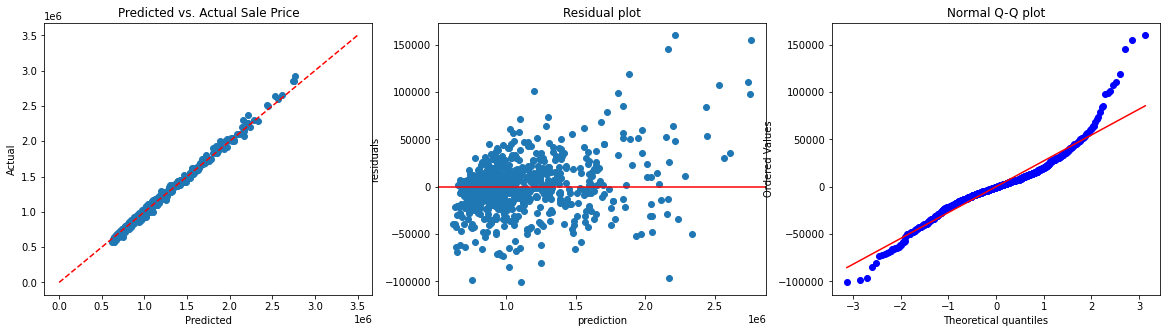

In [144]:
model_6.fit(X6_cv, y6_cv)

y6_pred = model_6.predict(X6_cv)

diagnostic_plots(X6_cv, y6_cv, y6_pred)

In [145]:
feature_importances = sorted(list(zip(X6_cv.columns, model_6.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft_X_schools', 0.1794958678576855),
 ('baths_X_lot_size', 0.12683514329763296),
 ('baths_X_hm_sqft', 0.12297385547112208),
 ('lot_size_X_schools', 0.11266501365547643),
 ('baths_X_schools', 0.09820008240119285),
 ('lot_size_SQ', 0.07030888551981467),
 ('hm_sqft_X_city_woodland_hills', 0.05637077926515097),
 ('lot_size_X_one_story', 0.04127314310824272),
 ('hm_sqft_X_city_encino', 0.03991015959012531),
 ('lot_size_X_city_woodland_hills', 0.03892030786477635),
 ('lot_size_X_city_encino', 0.03259753319019578),
 ('yr_built', 0.026651804073005443),
 ('hm_sqft_X_city_tarzana', 0.016540410546766006),
 ('schools_X_city_tarzana', 0.013645845125878008),
 ('hm_sqft_X_city_north_hills', 0.003742579257569772),
 ('hm_sqft_X_city_granada_hills', 0.003568532793011065),
 ('baths_X_city_chatsworth', 0.0021539790195659403),
 ('hm_sqft_X_city_winnetka', 0.001938796715469421),
 ('hm_sqft_X_city_reseda', 0.0019304855384746323),
 ('schools_X_city_west_hills', 0.0018979057583781937),
 ('garage_X_one_s

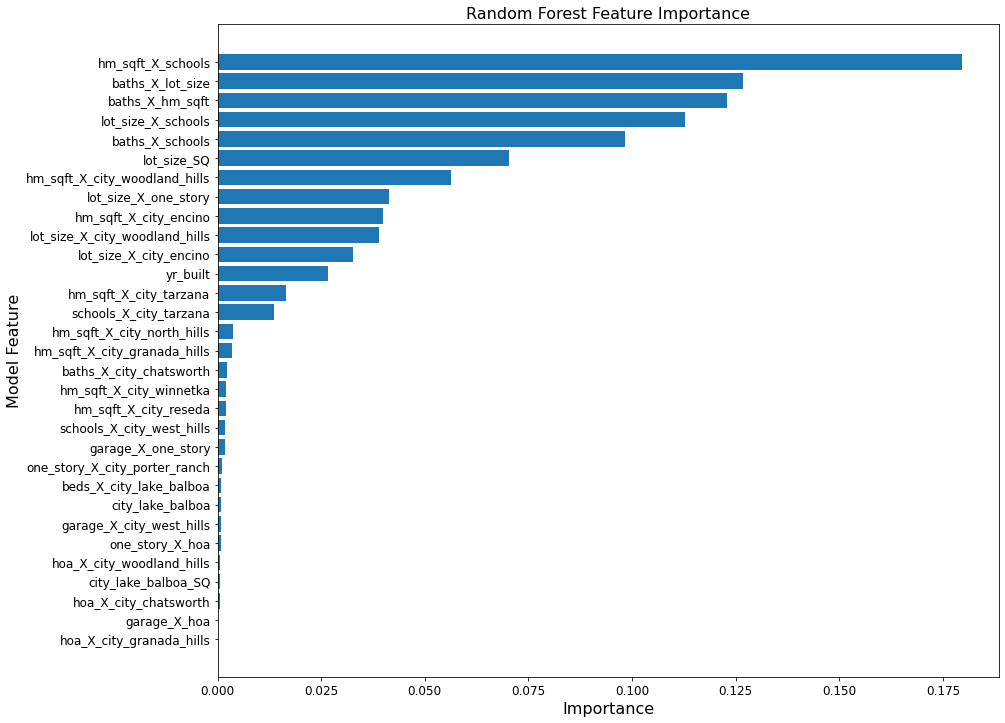

In [146]:
sorted_idx = model_6.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X6_cv.columns[sorted_idx], model_6.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

### Model 7 - XGBoost (with Lasso-selected variables)

In [232]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X7 = temp_df[['yr_built','city_lake_balboa']]

X7['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X7['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
X7['baths_X_lot_size'] = temp_df['baths'] * temp_df['lot_size']
X7['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X7['baths_X_city_chatsworth'] = temp_df['baths'] * temp_df['city_chatsworth']
X7['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X7['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X7['hm_sqft_X_city_granada_hills'] = temp_df['hm_sqft'] * temp_df['city_granada_hills']
X7['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X7['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X7['hm_sqft_X_city_tarzana'] = temp_df['hm_sqft'] * temp_df['city_tarzana']
X7['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X7['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X7['hm_sqft_X_city_woodland_hills'] = temp_df['hm_sqft'] * temp_df['city_woodland_hills']
X7['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X7['lot_size_X_schools'] = temp_df['lot_size'] * temp_df['schools']
X7['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X7['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X7['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X7['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X7['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X7['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X7['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X7['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X7['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X7['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X7['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X7['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X7['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']
X7['city_lake_balboa_SQ'] = temp_df['city_lake_balboa'] * temp_df['city_lake_balboa']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/1799214677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X7['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/1799214677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X7['baths_X_hm_sqft'] = temp_df['baths'] * temp_df['hm_sqft']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_61511/1799214677.py:6: SettingWithCopyWarning: 
A value i

In [233]:
X7_cv, X7_test, y7_cv, y7_test = train_test_split(X7, y, test_size=0.2, random_state=42)

In [149]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 2, 3, 5],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror', 'reg:pseudohubererror']
}

model_xgb = xgboost.XGBRegressor()

xgb_gridsearch = RandomizedSearchCV(estimator = model_xgb, 
                                   param_distributions = grid, 
                                   n_iter = 200, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

xgb_gridsearch.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [150]:
warnings.filterwarnings(action='ignore', category=UserWarning)
xgb_gridsearch.best_params_

{'subsample': 0.5,
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [151]:
warnings.filterwarnings(action='ignore', category=UserWarning)
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {
        'learning_rate': [0.005, 0.01, 0.02, 0.05],
        'max_depth': [1, 2, 3, 4],
        'min_child_weight': [1, 2],
        'subsample': [0.4, 0.5, 0.6],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'n_estimators' : [900, 1000, 1200],
        'objective': ['reg:squarederror']
}

# Perform grid search
grid_search = GridSearchCV(estimator = xgboost.XGBRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [152]:
warnings.filterwarnings(action='ignore', category=UserWarning)
grid_search.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.02,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [234]:
# Need this to filter annoying warnings (known bug/'feature' of XGBoost)
warnings.filterwarnings(action='ignore', category=UserWarning)

# model_xgb = xgboost.XGBRegressor(objective='reg:pseudohubererror', random_state=42)
model_7 = xgboost.XGBRegressor(
        subsample=0.5,
        objective='reg:squarederror',
        n_estimators=1000,
        min_child_weight=2,
        max_depth=2,
        learning_rate=0.02,
        colsample_bytree=0.6
)

cv_rsquareds(X7_cv, y7_cv, model_7, 5)
cv_maes(X7_cv, y7_cv, model_7, 5)
cv_rmse(X7_cv, y7_cv, model_7, 5)

CV R-squareds: [0.845, 0.878, 0.87, 0.829, 0.803]
Mean CV R-squared: 0.845 +/- 0.027

Adjusted CV R-squareds: [0.839, 0.873, 0.865, 0.822, 0.795]
Mean Adjusted CV R-squared: 0.839 +/- 0.028

CV MAEs: [104496, 96079, 102998, 106358, 119659]
Mean CV MAE: 105918 +/- 7699

CV RMSEs: [148289, 128568, 142319, 153225, 163735]
Mean CV RMSE: 147227 +/- 11678


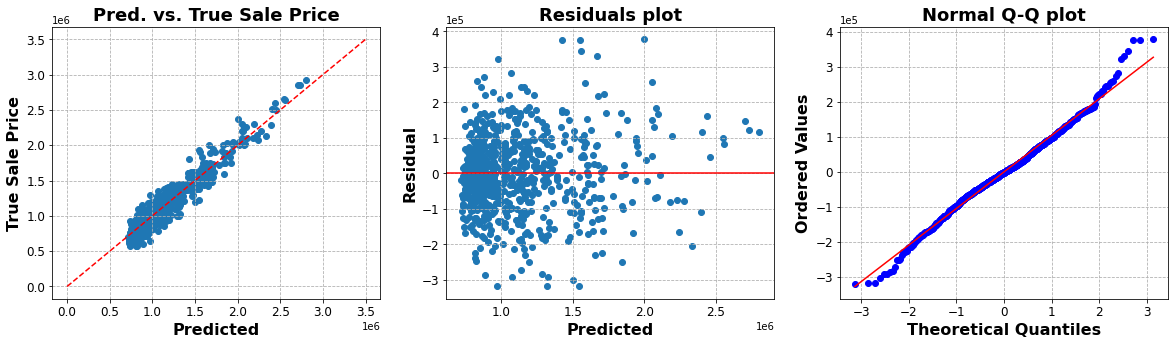

In [235]:
model_7.fit(X7_cv, y7_cv)

y7_pred = model_7.predict(X7_cv)

diagnostic_plots(X7_cv, y7_cv, y7_pred)

In [155]:
model_7.get_booster().get_score(importance_type="gain")

{'baths_X_hm_sqft': 551009183872.3574,
 'baths_X_lot_size': 887466856193.6187,
 'baths_X_schools': 469842783422.3684,
 'hm_sqft_X_schools': 1240030440595.5444,
 'lot_size_X_schools': 818924440635.8159,
 'lot_size_X_city_encino': 458420213071.9101,
 'lot_size_SQ': 189441179059.2262,
 'hm_sqft_X_city_encino': 431843943497.5325,
 'hm_sqft_X_city_woodland_hills': 215774382787.0583,
 'lot_size_X_one_story': 117035233118.49057,
 'hm_sqft_X_city_granada_hills': 99741406534.61539,
 'lot_size_X_city_woodland_hills': 235532074002.82486,
 'baths_X_city_chatsworth': 103439467325.0,
 'hm_sqft_X_city_tarzana': 296937010103.4524,
 'schools_X_city_tarzana': 342806083426.3889,
 'garage_X_city_west_hills': 111028556366.66667,
 'yr_built': 86696197855.75,
 'one_story_X_city_porter_ranch': 148469209125.0,
 'hm_sqft_X_city_reseda': 77046201060.60606,
 'hm_sqft_X_city_north_hills': 88806354780.86208,
 'garage_X_one_story': 94253029900.0,
 'schools_X_city_west_hills': 71122083795.45454,
 'one_story_X_hoa': 7

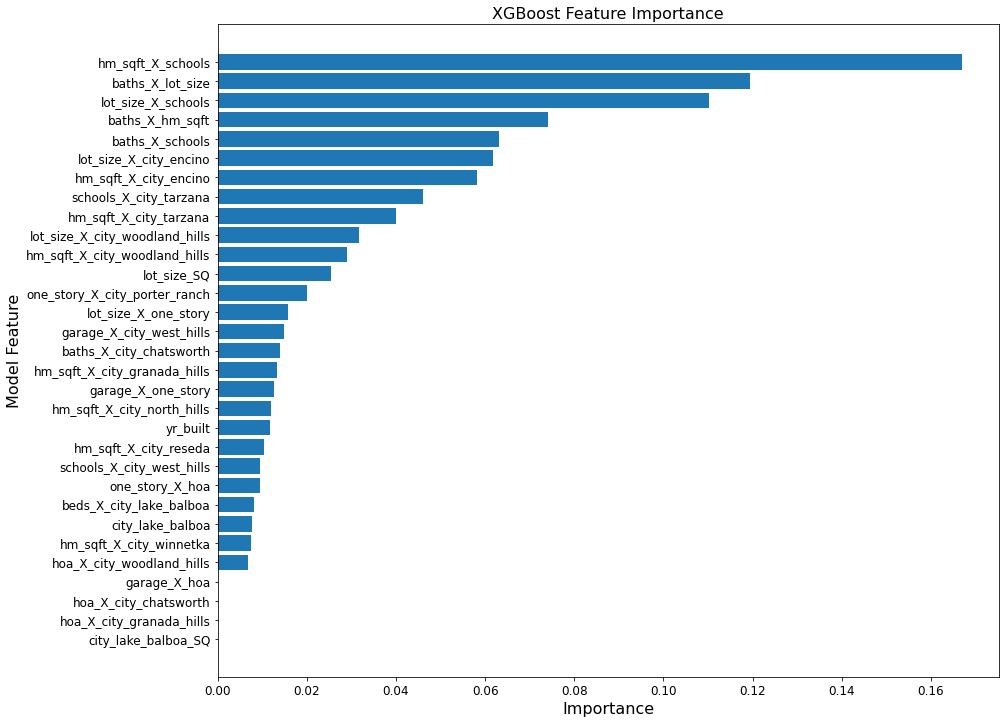

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [156]:
sorted_idx = model_7.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X7_cv.columns[sorted_idx], model_7.feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

In [177]:
feature_importances = sorted(list(zip(X7_cv.columns, model_7.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('baths_SQ', 0.10892594),
 ('baths', 0.106540404),
 ('hm_sqft', 0.09119952),
 ('city_encino', 0.08832954),
 ('hm_sqft_SQ', 0.068358816),
 ('lot_size_SQ', 0.06552617),
 ('lot_size', 0.046625346),
 ('city_woodland_hills', 0.043895043),
 ('schools_SQ', 0.036839087),
 ('city_tarzana', 0.03530909),
 ('schools', 0.030951388),
 ('beds', 0.029326834),
 ('city_granada_hills', 0.026343433),
 ('beds_SQ', 0.02360858),
 ('city_northridge', 0.023062486),
 ('city_north_hills', 0.019467805),
 ('city_porter_ranch', 0.019421715),
 ('one_story', 0.01866262),
 ('city_west_hills', 0.018288942),
 ('yr_built', 0.016722066),
 ('yr_built_SQ', 0.016434882),
 ('city_winnetka', 0.012835193),
 ('city_lake_balboa', 0.012622999),
 ('garage', 0.011065305),
 ('city_reseda', 0.010510167),
 ('city_chatsworth', 0.009804526),
 ('hoa', 0.009322044)]